In [1]:
import matplotlib as mpl

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

import torch

from sbi.analysis import pairplot

# load and read nwb files
from pynwb import NWBHDF5IO

# import sys
# sys.path.append('../code')

from ephys_utils_hh import get_time_voltage_current_currindex0, syn_current
from plot_utils import adjust_spines

/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


### Load observed data

In [2]:
M1_25degree = pickle.load(open("data/M1_features.pickle", "rb"))
ephys_features = np.array(M1_25degree["X_o"].columns)[:-4]
Xo = M1_25degree["X_o"].copy()
feature_list = range(23)

In [3]:
prop = pd.read_csv("data/m1_patchseq_meta_data.csv", sep="\t")
prop = prop.rename(columns={"Targeted layer": "Layer"})
prop = prop[["Cell", "Layer", "Cre", "RNA type"]]
prop = prop.set_index("Cell")
prop = prop.reindex(Xo.index)
no_low_qual = np.array(list(map(str, prop["RNA type"].values))) != "nan"
prop = prop.loc[no_low_qual, :]
Xo = Xo.loc[no_low_qual, :]
celltypes = prop["RNA type"]

In [4]:
annotations = pd.read_csv("data/cluster.annotation.csv", index_col=0)
cellTypeColors = {}
for celltype in np.unique(annotations["cluster_label"].values):
    cellTypeColors.update(
        {
            celltype: annotations.iloc[
                np.where(annotations["cluster_label"] == celltype)[0][0], :
            ]["cluster_color"]
        }
    )
colors = np.array([cellTypeColors[celltype] for celltype in celltypes])

In [5]:
model_param_names = np.array(
    [
        "C",
        r"$R_{input}$",
        r"$\tau$",
        r"$g_{Nat}$",
        r"$g_{Na}$",
        r"$g_{Kd}$",
        r"$g_{M}$",
        r"$g_{Kv31}$",
        r"$g_{L}$",
        r"$E_{leak}$",
        r"$\tau_{max}$",
        "VT",
        r"$r_{SS}$",
    ]
)
prior_min = [0.1, 20, 0.1, 0, 0, 0, 0, 0, 0, -130, 50, -90, 0.1]
prior_max = [15, 1000, 70, 250, 100, 30, 3, 250, 3, -50, 4000, -35, 3]

In [6]:
# Vip
celltype_Vip = (
    (celltypes == "Vip C1ql1")
    | (celltypes == "Vip Chat_1")
    | (celltypes == "Vip Gpc3")
    | (celltypes == "Vip Htr1f")
    | (celltypes == "Vip Mybpc1_1")
    | (celltypes == "Vip Mybpc1_2")
    | (celltypes == "Vip Mybpc1_3")
    | (celltypes == "Vip Serpinf1_1")
    | (celltypes == "Vip Serpinf1_2")
    | (celltypes == "Vip Serpinf1_3")
    | (celltypes == "Vip Sncg")
)

# Sst
celltype_Sst = (
    (celltypes == "Sst C1ql3_1")
    | (celltypes == "Sst C1ql3_2")
    | (celltypes == "Sst Calb2")
    | (celltypes == "Sst Chodl")
    | (celltypes == "Sst Crhr2_1")
    | (celltypes == "Sst Crhr2_2")
    | (celltypes == "Sst Etv1")
    | (celltypes == "Sst Hpse")
    | (celltypes == "Sst Htr1a")
    | (celltypes == "Sst Myh8_1")
    | (celltypes == "Sst Myh8_2")
    | (celltypes == "Sst Myh8_3")
    | (celltypes == "Sst Penk")
    | (celltypes == "Sst Pvalb Calb2")
    | (celltypes == "Sst Pvalb Etv1")
    | (celltypes == "Sst Tac2")
    | (celltypes == "Sst Th_1")
    | (celltypes == "Sst Th_3")
)

# Lamp5
celltype_Lamp5 = (
    (celltypes == "Lamp5 Egln3_1")
    | (celltypes == "Lamp5 Egln3_2")
    | (celltypes == "Lamp5 Lhx6")
    | (celltypes == "Lamp5 Pax6")
    | (celltypes == "Lamp5 Pdlim5_1")
    | (celltypes == "Lamp5 Pdlim5_2")
    | (celltypes == "Lamp5 Slc35d3")
)

# Pvalb
celltype_Pvalb = (
    (celltypes == "Pvalb Calb1_1")
    | (celltypes == "Pvalb Calb1_2")
    | (celltypes == "Pvalb Egfem1")
    | (celltypes == "Pvalb Gabrg1")
    | (celltypes == "Pvalb Gpr149")
    | (celltypes == "Pvalb Il1rapl2")
    | (celltypes == "Pvalb Kank4")
    | (celltypes == "Pvalb Reln")
    | (celltypes == "Pvalb Vipr2_2")
)

# Pyramidal
celltype_Pyr = (
    (celltypes == "L2/3 IT_3")
    | (celltypes == "L4/5 IT_1")
    | (celltypes == "L4/5 IT_2")
    | (celltypes == "L5 ET_1")
    | (celltypes == "L5 ET_2")
    | (celltypes == "L5 ET_3")
    | (celltypes == "L5 ET_4")
    | (celltypes == "L5 IT_1")
    | (celltypes == "L5 IT_2")
    | (celltypes == "L5 IT_3")
    | (celltypes == "L5 IT_4")
    | (celltypes == "L5/6 NP CT")
    | (celltypes == "L5/6 NP_1")
    | (celltypes == "L5/6 NP_2")
    | (celltypes == "L6 CT Cpa6")
    | (celltypes == "L6 CT Grp")
    | (celltypes == "L6 CT Pou3f2")
    | (celltypes == "L6 IT_1")
    | (celltypes == "L6 IT_2")
    | (celltypes == "L6b Col6a1")
    | (celltypes == "L6b Kcnip1")
    | (celltypes == "L6b Ror1")
    | (celltypes == "L6b Shisa6_1")
    | (celltypes == "L6b Shisa6_2")
)
# Sncg
celltype_Sncg = (
    (celltypes == "Sncg Calb1_2")
    | (celltypes == "Sncg Npy2r")
    | (celltypes == "Sncg Calb1_1")
    | (celltypes == "Sncg Col14a1")
)

### Illustrate model mismatch

In [7]:
dir_locs = []
for cell_name in Xo.index:
    dir_locs.append(
        np.array(M1_25degree["M1_names"])[no_low_qual][
            np.where(Xo.index == cell_name)[0][0]
        ]
    )

Pick example cell

In [8]:
cell_name = "20180529_sample_3"

In [10]:
# Check whether raw file name corresponds to the cell's name
data = np.array(M1_25degree["M1_names"])[no_low_qual][
    np.where(Xo.index == cell_name)[0][0]
]
data

'../data/raw_data/000008/sub-mouse-PAIFP/sub-mouse-PAIFP_ses-20180529-sample-3_slice-20180529-slice-3_cell-20180529-sample-3_icephys.nwb'

In [11]:
data = './data/raw_data/'+data.split('/')[-1]

In [12]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data = NWBHDF5IO(data, "r", load_namespaces=True).read()

In [13]:
xo = Xo.loc[cell_name, :].iloc[:-4].values
feature_list = range(23)

In [14]:
(
    time_obs,
    voltage_obs,
    current_obs,
    curr_index_0_obs,
) = get_time_voltage_current_currindex0(data)
liquid_junction_potential = 15.4
voltage_obs -= liquid_junction_potential

I, t_on, t_off, dt, t, A_soma = syn_current(
    area=Xo.loc[cell_name, "1-comp area"], curr_level=3e-4
)
curr_index = np.where(current_obs == 300)[0][0]
observation = {
    "data": voltage_obs[:20000, curr_index],
    "time": time_obs[:20000] * 1e3,
    "dt": 4 * 1e-5 * 1e3,
    "I": I,
}

In [15]:
# load prior simulations
theta = np.load("data/full_batch.npz")["theta"]
stats = np.load("data/full_batch.npz")["stats"]
keeping = (~np.isnan(np.mean(stats, axis=1))) & (
    ~np.isinf(np.mean(stats, axis=1))
)  # delete non-spiking simulations
stats = stats[keeping, :]
theta = theta[keeping, :]

tcmalloc: large alloc 1380007936 bytes == 0x39c24000 @ 


In [16]:
# find 1000 prior simulations closest to the experimental observation in terms of Z-scored ephys distance
s_mean = stats[:, feature_list].mean(axis=0)
s_std = stats[:, feature_list].std(axis=0)
E_distances = np.sort(
    np.sqrt(
        np.sum(
            (
                (stats[:, feature_list] - s_mean) / s_std
                - (xo[feature_list] - s_mean) / s_std
            )
            ** 2,
            axis=1,
        )
    )
)[0:1000]

tcmalloc: large alloc 1316626432 bytes == 0xb7b94000 @ 


Next blocks can take a while. If performed once, you don't need to run it again and can just go to loading the saved files.

In [ ]:
# Uncomment this block to recompute

# # now do it for all experimental observations
# s_mean=stats[:,feature_list].mean(axis=0)
# s_std=stats[:,feature_list].std(axis=0)
# E_distances_observations=[]
# for i in range(Xo.shape[0]):
#     if i%10==0:
#         print(i,' ', end='')
#     E_distances_one=np.sort(
#         np.sqrt(
#             np.sum(
#                 (
#                     (stats[:,feature_list]-s_mean)/s_std
#                     -(Xo.values[i,feature_list]-s_mean)/s_std
#                 )**2,axis=1
#             )
#         )
#     )[0:1000]
#     E_distances_observations.append(E_distances_one)
# E_distances_observations=np.array(E_distances_observations)
# np.savez('../code/save_sims/E_distances_observations.npz',
#      distances=E_distances_observations
#         )

In [17]:
E_distances_prior = np.load("data/E_distances_prior.npz")["distances"]
E_distances_prior_indices = np.load("data/E_distances_prior.npz")[
    "indices"
]
E_distances_observations = np.load("data/E_distances_observations.npz")[
    "distances"
]

In [18]:
from simulator import EphysModel

M1_model = EphysModel(
    name="M1",
    T=25.0,
    E_Na=69.0,
    E_K=-98.4,
    E_Ca=127.2,
    start=100,
    end=700,
    dt=0.04,
    n_processes=40,
    noise_factor=10,
    use_pathos=True,
    chunk_size=280,
    save_chunks=True,
)

In [19]:
s_mean = stats[:, feature_list].mean(axis=0)
s_std = stats[:, feature_list].std(axis=0)
E_distances_indexes = np.argsort(
    np.sqrt(
        np.sum(
            (
                (stats[:, feature_list] - s_mean) / s_std
                - (xo[feature_list] - s_mean) / s_std
            )
            ** 2,
            axis=1,
        )
    )
)[0:1000]
x_prior = M1_model._run_HH_model(theta[E_distances_indexes[[1, 100, 500]], :])

In [20]:
sim_ind_ex = E_distances_prior_indices[
    np.argsort(E_distances_prior[:, -1])[round(E_distances_prior.shape[0] // 2.2)]
]

In [21]:
# find 1000 prior simulations closest to a simulation in terms of Z-scored ephys distance
s_mean = stats[:, feature_list].mean(axis=0)
s_std = stats[:, feature_list].std(axis=0)
E_distances_ex = np.sort(
    np.sqrt(
        np.sum(
            (
                (stats[:, feature_list] - s_mean) / s_std
                - (stats[sim_ind_ex, feature_list] - s_mean) / s_std
            )
            ** 2,
            axis=1,
        )
    )
)[0:1000]

In [22]:
s_mean = stats[:, feature_list].mean(axis=0)
s_std = stats[:, feature_list].std(axis=0)
E_distances_ex_indexes = np.argsort(
    np.sqrt(
        np.sum(
            (
                (stats[:, feature_list] - s_mean) / s_std
                - (stats[sim_ind_ex, feature_list] - s_mean) / s_std
            )
            ** 2,
            axis=1,
        )
    )
)[0:1000]
x_sim_prior = M1_model._run_HH_model(theta[E_distances_ex_indexes[[1, 100, 500]], :])

In [23]:
x_sim_ex = M1_model._run_HH_model(theta[sim_ind_ex, :])

In [24]:
fancy_colors = (
    np.array(
        [
            [86, 100, 26],
            [192, 175, 251],
            [230, 161, 118],
            [0, 103, 138],
            [152, 68, 100],
            [94, 204, 171],
            [205, 205, 205],
        ]
    )
    / 255
)

In [25]:
def create_figure_1d(fig):
    if fig is None:
        fig = plt.figure(figsize=(14, 8))
    else:
        fig = fig

    width = 0.14  # for membrane voltage traces
    height = 0.45  # for membrane voltage traces
    ax_mm_banana = plt.axes([0, 0.15, 0.36, 0.8])
    axes_ex_1 = np.array(
        [plt.axes([x, 0.50, width, height]) for x in [0.41, 0.56, 0.71, 0.86]]
    )
    axes_ex_2 = np.array(
        [plt.axes([x, 0.1, width, height]) for x in [0.41, 0.56, 0.71, 0.86]]
    )

    return ax_mm_banana, axes_ex_1, axes_ex_2

Text(-0.05, 0.97, 'd')

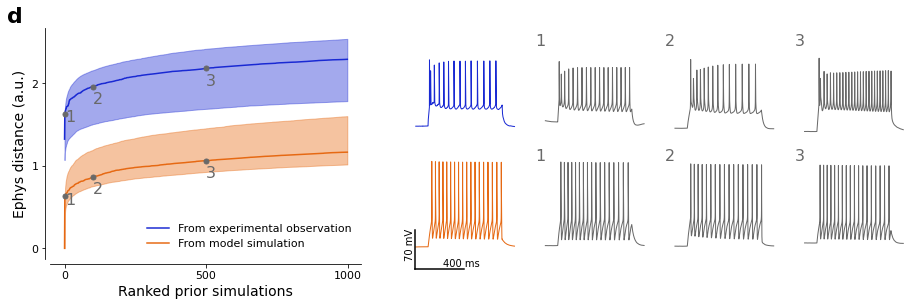

In [26]:
fig = plt.figure(figsize=(12, 4))
ax_mm_banana, axes_ex_1, axes_ex_2 = create_figure_1d(fig)

lw = 1


# Model mismatch, banana
ax_mm_banana.plot(
    range(1000), E_distances, c="#1929d3ff", label="From experimental observation"
)
ax_mm_banana.plot(E_distances_ex, c="#e66913ff", label="From model simulation")
ax_mm_banana.fill_between(
    range(1000),
    np.percentile(E_distances_prior, 30, axis=0),
    np.percentile(E_distances_prior, 70, axis=0),
    color="#e66913ff",
    alpha=0.4,
)
ax_mm_banana.fill_between(
    range(1000),
    np.percentile(E_distances_observations, 30, axis=0),
    np.percentile(E_distances_observations, 70, axis=0),
    color="#1929d3ff",
    alpha=0.4,
)

ax_mm_banana.plot([1], [E_distances[1]], color="dimgray", marker=".", markersize=10)
ax_mm_banana.plot([100], [E_distances[100]], color="dimgray", marker=".", markersize=10)
ax_mm_banana.plot([500], [E_distances[500]], color="dimgray", marker=".", markersize=10)
ax_mm_banana.plot([1], [E_distances_ex[1]], color="dimgray", marker=".", markersize=10)
ax_mm_banana.plot(
    [100], [E_distances_ex[100]], color="dimgray", marker=".", markersize=10
)
ax_mm_banana.plot(
    [500], [E_distances_ex[500]], color="dimgray", marker=".", markersize=10
)

ax_mm_banana.annotate("1", (1, E_distances[1] - 0.1), color="dimgray", fontsize=16)
ax_mm_banana.annotate("2", (100, E_distances[100] - 0.2), color="dimgray", fontsize=16)
ax_mm_banana.annotate("3", (500, E_distances[500] - 0.2), color="dimgray", fontsize=16)
ax_mm_banana.annotate("1", (1, E_distances_ex[1] - 0.1), color="dimgray", fontsize=16)
ax_mm_banana.annotate(
    "2", (100, E_distances_ex[100] - 0.2), color="dimgray", fontsize=16
)
ax_mm_banana.annotate(
    "3", (500, E_distances_ex[500] - 0.2), color="dimgray", fontsize=16
)
ax_mm_banana.set_xlabel("Ranked prior simulations", fontsize=14)
ax_mm_banana.set_ylabel("Ephys distance (a.u.)", fontsize=14)

ax_mm_banana.set_xticks([0, 500, 1000])
ax_mm_banana.set_yticks([0, 1, 2])
ax_mm_banana.tick_params(axis="both", which="major", labelsize=11)

ax_mm_banana.legend(loc="lower right", fontsize=11, frameon=False)

adjust_spines(ax_mm_banana, spines=["bottom", "left"])

# Experimental observation and prior simulations close to it
axes_ex_1[0].plot(observation["time"], observation["data"], c="#1929d3ff", lw=lw)
axes_ex_1[0].set_ylim(
    [axes_ex_1[0].get_ylim()[0] - 50, axes_ex_1[0].get_ylim()[1] + 50]
)
axes_ex_1[0].set_xlim(
    [axes_ex_1[0].get_xlim()[0] - 50, axes_ex_1[0].get_xlim()[1] + 50]
)
# axes_ex_1[0].set_title('Experimental observation', fontsize=16)
axes_ex_1[0].set_xticks([])
axes_ex_1[0].set_yticks([])
sns.despine(ax=axes_ex_1[0], bottom=True, left=True)


for i, ax in enumerate(axes_ex_1[1:]):
    ax.plot(x_prior["time"], x_prior["data"][i, 0, :], lw=lw, color="dimgray")
    # ToDo NEED THIS ??
    ax.set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
    ax.set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
    ax.annotate(
        i + 1, (ax.get_xlim()[0] + 10, ax.get_ylim()[1] - 30), fontsize=16, c="dimgray"
    )
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True, left=True)


# Prior simulation and prior simulations close to it
axes_ex_2[0].plot(x_sim_ex["time"], x_sim_ex["data"][0, 0, :], c="#e66913ff", lw=lw)
axes_ex_2[0].set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
axes_ex_2[0].set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
# axes_ex_2[0].set_title('Model simulation', fontsize=16)
axes_ex_2[0].set_xticks([])
axes_ex_2[0].set_yticks([])
sns.despine(ax=axes_ex_2[0], bottom=True, left=True)

for i, ax in enumerate(axes_ex_2[1:]):
    ax.plot(x_sim_prior["time"], x_sim_prior["data"][i, 0, :], lw=lw, color="dimgray")
    ax.set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
    ax.set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
    ax.annotate(
        i + 1, (ax.get_xlim()[0] + 10, ax.get_ylim()[1] - 30), fontsize=16, c="dimgray"
    )
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True, left=True)

axes_ex_2[0].plot([-10, 390], [-140, -140], "k")
axes_ex_2[0].annotate("400 ms", (220, -135))
axes_ex_2[0].plot([-10, -10], [-140, -70], "k")
axes_ex_2[0].annotate("70 mV", (-89, -120), rotation=90)

fig.text(-0.05, 0.97, "d", fontsize=22, fontweight="bold")

# plt.savefig("figure_1d.png", bbox_inches="tight", pad_inches=0)
# plt.savefig("figure_1d.pdf", bbox_inches="tight", pad_inches=0)

### NPE, then NPE-N

How we overcome model mismatch with neural posterior estimation.

In [27]:
with open("data/posteriors/training_schedule_0.pickle", "rb") as f:
    npe_posterior = pickle.load(f)
with open("data/posteriors/training_schedule_2d.pickle", "rb") as f:
    npep_posterior = pickle.load(f)

Fetch 3 posterior samples with highest posterior weight. Get there corresponding simulations and summary statistics. You can also immediately load the simulations that come with the figure from the GitHub repo and skip this cell.

In [48]:
#Uncomment this block to recompute

npe_samples=npe_posterior.sample(
    (10000,),
    x=torch.as_tensor(xo[feature_list], dtype=float),
)
npe_samples=npe_samples[np.argsort(np.array(npe_posterior.log_prob(theta=npe_samples, x=xo[feature_list])))[-3:],:]
npep_samples=npep_posterior.sample(
    (10000,),
    x=torch.as_tensor(xo[feature_list], dtype=float),
)
npep_samples=npep_samples[np.argsort(np.array(npep_posterior.log_prob(theta=npep_samples, x=xo[feature_list])))[-3:],:]
x_npe=M1_model._run_HH_model(npe_samples.numpy())
x_npep=M1_model._run_HH_model(npep_samples.numpy())

summ_stats_npe=M1_model._simulation_wrapper(npe_samples[-1,:].numpy()[np.newaxis,:]).numpy()[0,:]
summ_stats_npep=M1_model._simulation_wrapper(npep_samples[-1,:].numpy()[np.newaxis,:]).numpy()[0,:]

sims_to_show={
    'npe':{'samples':npe_samples, 'x':x_npe, 'summ_stats':summ_stats_npe},
    'npep':{'samples':npep_samples, 'x':x_npep, 'summ_stats':summ_stats_npep}
}

# with open('data/model_parameters/{}.pickle'.format(cell_name), 'wb') as f:
#     pickle.dump(sims_to_show, f)

In [30]:
with open("data/model_parameters/{}.pickle".format(cell_name), "rb") as f:
    sims_to_show = pickle.load(f)

In [32]:
npe_samples = sims_to_show["npe"]["samples"]
x_npe = sims_to_show["npe"]["x"]
summ_stats_npe = sims_to_show["npe"]["summ_stats"]

npep_samples = sims_to_show["npep"]["samples"]
x_npep = sims_to_show["npep"]["x"]
summ_stats_npep = sims_to_show["npep"]["summ_stats"]

In [55]:
obs_index = np.where(Xo.index == cell_name)[0][0]

# best_prior_stats = np.load("../code/save_sims/best_1000_Euclidean_sims.npz")["stats"][
#     ::1000, :
# ]
# best_prior_stats_nans = np.isnan(best_prior_stats.sum(axis=1))

Xo_values = Xo.values[:, :-4]
Xo_mean = Xo.values[:, :-4].mean(axis=0)
Xo_std = Xo.values[:, :-4].std(axis=0)


# prior_score = np.sqrt(
#     (
#         (best_prior_stats[obs_index, :] - Xo_mean) / Xo_std
#         - (Xo_values[obs_index, :] - Xo_mean) / Xo_std
#     )
#     ** 2
# )

npe_score = np.sqrt(
    ((summ_stats_npe - Xo_mean) / Xo_std - (Xo_values[obs_index, :] - Xo_mean) / Xo_std)
    ** 2
)

npep_score = np.sqrt(
    (
        (summ_stats_npep - Xo_mean) / Xo_std
        - (Xo_values[obs_index, :] - Xo_mean) / Xo_std
    )
    ** 2
)

In [129]:
mpl.rcParams.update({"font.size": 14})

In [152]:
def create_figure_ver(fig):
    if fig is None:
        fig = plt.figure(figsize=(5, 9))
    else:
        fig = fig

    width, height = 0.18, 0.073
    
    ax_features = plt.axes([0.3, 0.58, .6, 0.42])
    
    ax_observation = plt.axes([0.6, 0.6, width+.2, height])
    
    axes_npe = np.array(
        [
            [
                plt.axes([x, y, width, height])
                for x in [0.12, 0.34, 0.56, 0.78]
            ]
            for y in [0.4, 0.3, 0.2, 0.1]
        ]
    )
    
    ax_sim1 = plt.axes([-.1, 0.16, width+.2, height])
    ax_sim2 = plt.axes([0.05, 0.08, width+.2, height])
    ax_sim3 = plt.axes([0.2, 0, width+.2, height])

    return ax_features, axes_npe, ax_observation, ax_sim1, ax_sim2, ax_sim3

WARNING    /gpfs01/berens/user/ybernaerts/.local/lib/python3.8/site-packages/sbi/analysis/plot.py:731: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:
 [py.warnings]


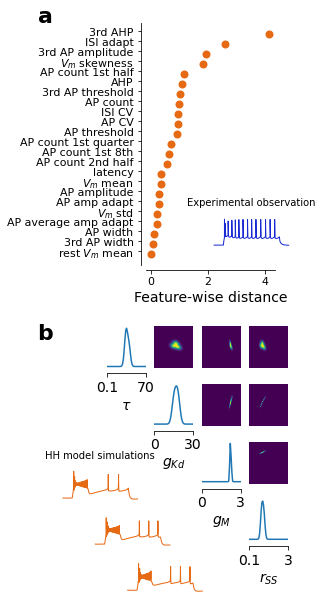

In [111]:
dims_to_show = [2, 5, 6, 12]
lw = 1

fig = plt.figure(figsize=(3, 8))
ax_features, axes_npe, ax_observation, ax_sim1, ax_sim2, ax_sim3 = create_figure_ver(fig)

# Feature-wise performances NPE vs NPE+
order = np.argsort(npe_score)

ax_features.scatter(
    npe_score[order],
    np.linspace(0, 4 * len(ephys_features) + 1, num=len(ephys_features)),
    color="#e66913ff",
    label="NPE",
    lw=2,
)
adjust_spines(ax_features, spines=["bottom", "left"])
ax_features.set_yticks(
    np.linspace(1, 4 * len(ephys_features) + 2, num=len(ephys_features))
)
#ax_features.legend(loc=(0.05, 0.7), fontsize=11, frameon=False)
ax_features.set_xlabel("Feature-wise distance", fontsize=14)
ax_features.set_yticklabels(ephys_features[order])
ax_features.tick_params(axis="y", which="major", labelsize=11)
ax_features.tick_params(axis="x", which="major", labelsize=11)


# Experimental observation
ax_observation.plot(observation["time"], observation["data"], c="#1929d3ff", lw=lw)
ax_observation.set_ylim(
    [ax_observation.get_ylim()[0] - 30, ax_observation.get_ylim()[1] + 30]
)
ax_observation.set_xticks([])
ax_observation.set_yticks([])
sns.despine(ax=ax_observation, bottom=True, left=True)
ax_observation.set_title('Experimental observation', fontsize=10)

# SBI pairplot
pairplot(
    npe_samples[:, dims_to_show],
    limits=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    ticks=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    labels=np.array(model_param_names[dims_to_show]),
    points_offdiag={"markersize": 6},
    points_colors="r",
    fig=fig,
    axes=axes_npe,
    upper="kde",
    diag="kde",
)

ax_sim1.plot(x_npe["time"], x_npe["data"][0, 0, :], lw=lw, color="#e66913ff")
ax_sim2.plot(x_npe["time"], x_npe["data"][1, 0, :], lw=lw, color="#e66913ff")
ax_sim3.plot(x_npe["time"], x_npe["data"][2, 0, :], lw=lw, color="#e66913ff")

for ax in [
    ax_sim1,
    ax_sim2,
    ax_sim3
]:
    ax.set_ylim([ax_observation.get_ylim()[0], ax_observation.get_ylim()[1]])
    ax.set_xlim([ax_observation.get_xlim()[0], ax_observation.get_xlim()[1]])
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True, left=True)
ax_sim1.set_title('HH model simulations', fontsize=10)

fig.text(-0.2, 1, "a", fontsize=22, fontweight="bold")
fig.text(-0.2, 0.45, "b", fontsize=22, fontweight="bold")

plt.savefig("figures/npe_{}.pdf".format(cell_name), bbox_inches="tight", pad_inches=0)

#### Feedforwarding a HH model simulation itself:

In [496]:
sim_index=np.random.randint(0,stats.shape[0])
sim_index

1625693

In [497]:
x_sim = M1_model._run_HH_model(theta[sim_index,:])

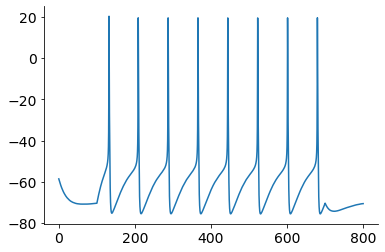

In [498]:
plt.plot(x_sim['time'], x_sim['data'][0,0,:])

In [499]:
#Uncomment this block to recompute

npe_samples=npe_posterior.sample(
    (10000,),
    x=torch.as_tensor(stats[sim_index,:][feature_list], dtype=float),
)
npe_samples=npe_samples[np.argsort(np.array(npe_posterior.log_prob(theta=npe_samples, x=stats[sim_index,:][feature_list])))[-3:],:]
npep_samples=npep_posterior.sample(
    (10000,),
    x=torch.as_tensor(stats[sim_index,:][feature_list], dtype=float),
)
npep_samples=npep_samples[np.argsort(np.array(npep_posterior.log_prob(theta=npep_samples, x=stats[sim_index,:][feature_list])))[-3:],:]
x_npe=M1_model._run_HH_model(npe_samples.numpy())
x_npep=M1_model._run_HH_model(npep_samples.numpy())

summ_stats_npe=M1_model._simulation_wrapper(npe_samples[-1,:].numpy()[np.newaxis,:]).numpy()[0,:]
summ_stats_npep=M1_model._simulation_wrapper(npep_samples[-1,:].numpy()[np.newaxis,:]).numpy()[0,:]

sims_to_show={
    'npe':{'samples':npe_samples, 'x':x_npe, 'summ_stats':summ_stats_npe},
    'npep':{'samples':npep_samples, 'x':x_npep, 'summ_stats':summ_stats_npep}
}

with open('data/model_parameters/sim_as_truth.pickle', 'wb') as f:
    pickle.dump(sims_to_show, f)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [500]:
with open("data/model_parameters/sim_as_truth.pickle", "rb") as f:
    sims_to_show = pickle.load(f)

In [501]:
npe_samples = sims_to_show["npe"]["samples"]
x_npe = sims_to_show["npe"]["x"]
summ_stats_npe = sims_to_show["npe"]["summ_stats"]

npep_samples = sims_to_show["npep"]["samples"]
x_npep = sims_to_show["npep"]["x"]
summ_stats_npep = sims_to_show["npep"]["summ_stats"]

In [502]:
npe_score = np.sqrt(
    ((summ_stats_npe - Xo_mean) / Xo_std - (stats[sim_index,:][feature_list] - Xo_mean) / Xo_std)
    ** 2
)

npep_score = np.sqrt(
    (
        (summ_stats_npep - Xo_mean) / Xo_std
        - (stats[sim_index,:][feature_list] - Xo_mean) / Xo_std
    )
    ** 2
)

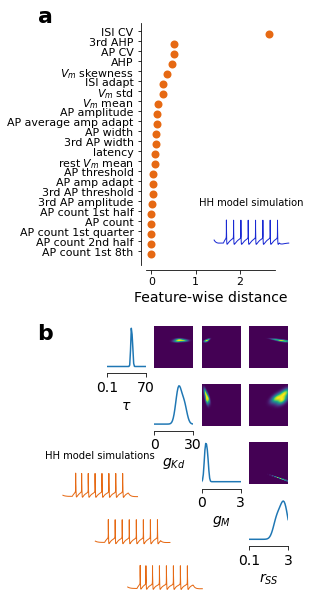

In [504]:
dims_to_show = [2, 5, 6, 12]
lw = 1

fig = plt.figure(figsize=(3, 8))
ax_features, axes_npe, ax_observation, ax_sim1, ax_sim2, ax_sim3 = create_figure_ver(fig)

# Feature-wise performances NPE vs NPE+
order = np.argsort(npe_score)

ax_features.scatter(
    npe_score[order],
    np.linspace(0, 4 * len(ephys_features) + 1, num=len(ephys_features)),
    color="#e66913ff",
    label="NPE",
    lw=2,
)
adjust_spines(ax_features, spines=["bottom", "left"])
ax_features.set_yticks(
    np.linspace(1, 4 * len(ephys_features) + 2, num=len(ephys_features))
)
#ax_features.legend(loc=(0.05, 0.7), fontsize=11, frameon=False)
ax_features.set_xlabel("Feature-wise distance", fontsize=14)
ax_features.set_yticklabels(ephys_features[order])
ax_features.tick_params(axis="y", which="major", labelsize=11)
ax_features.tick_params(axis="x", which="major", labelsize=11)


# Experimental observation
ax_observation.plot(x_sim["time"], x_sim["data"][0,0,:], c="#1929d3ff", lw=lw)
ax_observation.set_ylim(
    [ax_observation.get_ylim()[0] - 30, ax_observation.get_ylim()[1] + 30]
)
ax_observation.set_xticks([])
ax_observation.set_yticks([])
sns.despine(ax=ax_observation, bottom=True, left=True)
ax_observation.set_title('HH model simulation', fontsize=10)

# SBI pairplot
pairplot(
    npe_samples[:, dims_to_show],
    limits=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    ticks=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    labels=np.array(model_param_names[dims_to_show]),
    points_offdiag={"markersize": 6},
    points_colors="r",
    fig=fig,
    axes=axes_npe,
    upper="kde",
    diag="kde",
)

ax_sim1.plot(x_npe["time"], x_npe["data"][0, 0, :], lw=lw, color="#e66913ff")
ax_sim2.plot(x_npe["time"], x_npe["data"][1, 0, :], lw=lw, color="#e66913ff")
ax_sim3.plot(x_npe["time"], x_npe["data"][2, 0, :], lw=lw, color="#e66913ff")

for ax in [
    ax_sim1,
    ax_sim2,
    ax_sim3
]:
    ax.set_ylim([ax_observation.get_ylim()[0], ax_observation.get_ylim()[1]])
    ax.set_xlim([ax_observation.get_xlim()[0], ax_observation.get_xlim()[1]])
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True, left=True)
ax_sim1.set_title('HH model simulations', fontsize=10)

fig.text(-0.2, 1, "a", fontsize=22, fontweight="bold")
fig.text(-0.2, 0.45, "b", fontsize=22, fontweight="bold")

plt.savefig("figures/npen_sim_as_truth.pdf", bbox_inches="tight", pad_inches=0)

### NPE together with NPE-N, one big figure

Illustrate npe vn npe-n in bigger figure for multiple cells.

Pick example cell

In [309]:
cell_name = '20190418_sample_8' # Pvalb Calb1_1

In [387]:
cell_name = '20181109_sample_9' # Sst Crhr2_1

In [295]:
cell_name = '20190626_sample_1' # Vip Serpinf1_1

In [427]:
cell_name = '20190327_sample_2' # L6 CT Cpa6

In [458]:
cell_name = '20190515_sample_7' # Lamp5 Egln3_1

In [444]:
cell_name = '20190418_sample_2' # Sst Th_1 # example where both npe and npe-n fail

In [459]:
prop.loc[cell_name,:]

Layer                   1
Cre                  VIP-
RNA type    Lamp5 Egln3_1
Name: 20190515_sample_7, dtype: object

In [460]:
# Check whether raw file name corresponds to the cell's name
data = np.array(M1_25degree["M1_names"])[no_low_qual][
    np.where(Xo.index == cell_name)[0][0]
]
data

'../data/raw_data/000008/sub-mouse-AVLEY/sub-mouse-AVLEY_ses-20190515-sample-7_slice-20190515-slice-7_cell-20190515-sample-7_icephys.nwb'

In [461]:
data = './data/raw_data/'+data.split('/')[-1]

In [462]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data = NWBHDF5IO(data, "r", load_namespaces=True).read()

In [463]:
xo = Xo.loc[cell_name, :].iloc[:-4].values
feature_list = range(23)

In [464]:
(
    time_obs,
    voltage_obs,
    current_obs,
    curr_index_0_obs,
) = get_time_voltage_current_currindex0(data)
liquid_junction_potential = 15.4
voltage_obs -= liquid_junction_potential

I, t_on, t_off, dt, t, A_soma = syn_current(
    area=Xo.loc[cell_name, "1-comp area"], curr_level=3e-4
)
curr_index = np.where(current_obs == 300)[0][0]
observation = {
    "data": voltage_obs[:20000, curr_index],
    "time": time_obs[:20000] * 1e3,
    "dt": 4 * 1e-5 * 1e3,
    "I": I,
}

Text(0.5, 1.0, 'Experimental observation')

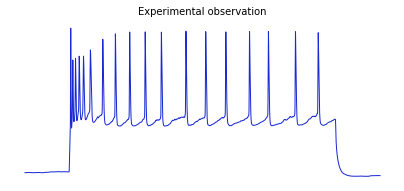

In [465]:
# Experimental observation
fig, ax = plt.subplots(1,1,figsize=(7,3))
ax.plot(observation["time"], observation["data"], c="#1929d3ff", lw=lw)
ax.set_xticks([])
ax.set_yticks([])
sns.despine(ax=ax, bottom=True, left=True)
ax.set_title('Experimental observation', fontsize=10)

In [466]:
#Uncomment this block to recompute

npe_samples=npe_posterior.sample(
    (10000,),
    x=torch.as_tensor(xo[feature_list], dtype=float),
)
npe_samples=npe_samples[np.argsort(np.array(npe_posterior.log_prob(theta=npe_samples, x=xo[feature_list])))[-3:],:]
npep_samples=npep_posterior.sample(
    (10000,),
    x=torch.as_tensor(xo[feature_list], dtype=float),
)
npep_samples=npep_samples[np.argsort(np.array(npep_posterior.log_prob(theta=npep_samples, x=xo[feature_list])))[-3:],:]
x_npe=M1_model._run_HH_model(npe_samples.numpy())
x_npep=M1_model._run_HH_model(npep_samples.numpy())

summ_stats_npe=M1_model._simulation_wrapper(npe_samples[-1,:].numpy()[np.newaxis,:]).numpy()[0,:]
summ_stats_npep=M1_model._simulation_wrapper(npep_samples[-1,:].numpy()[np.newaxis,:]).numpy()[0,:]

sims_to_show={
    'npe':{'samples':npe_samples, 'x':x_npe, 'summ_stats':summ_stats_npe},
    'npep':{'samples':npep_samples, 'x':x_npep, 'summ_stats':summ_stats_npep}
}

with open('data/model_parameters/{}.pickle'.format(cell_name), 'wb') as f:
    pickle.dump(sims_to_show, f)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [467]:
with open("data/model_parameters/{}.pickle".format(cell_name), "rb") as f:
    sims_to_show = pickle.load(f)

In [468]:
npe_samples = sims_to_show["npe"]["samples"]
x_npe = sims_to_show["npe"]["x"]
summ_stats_npe = sims_to_show["npe"]["summ_stats"]

npep_samples = sims_to_show["npep"]["samples"]
x_npep = sims_to_show["npep"]["x"]
summ_stats_npep = sims_to_show["npep"]["summ_stats"]

In [469]:
obs_index = np.where(Xo.index == cell_name)[0][0]

Xo_values = Xo.values[:, :-4]
Xo_mean = Xo.values[:, :-4].mean(axis=0)
Xo_std = Xo.values[:, :-4].std(axis=0)

npe_score = np.sqrt(
    ((summ_stats_npe - Xo_mean) / Xo_std - (Xo_values[obs_index, :] - Xo_mean) / Xo_std)
    ** 2
)

npep_score = np.sqrt(
    (
        (summ_stats_npep - Xo_mean) / Xo_std
        - (Xo_values[obs_index, :] - Xo_mean) / Xo_std
    )
    ** 2
)

In [470]:
def create_figure_hor(fig):
    if fig is None:
        fig = plt.figure(figsize=(14, 5))
    else:
        fig = fig

    width, height = 0.04, 0.12
    ax_features = plt.axes([0, 0, 0.12, 1])
    ax_observation = plt.axes([.02, .01, width+.15, height+.03])
    axes_npe = np.array(
        [
            [
                plt.axes([0.15 + x, y, width, height])
                for x in [0, .06, .12, .18, .24, .3, .36]
            ]
            for y in [.86, .72, .58, .44, .3, .16, .02]
        ]
    )
    
    ax_npe_s1 = plt.axes([.13, 0.3, width+.15, height+.03])
    ax_npe_s2 = plt.axes([0.18, 0.15, width+.15, height+.03])
    ax_npe_s3 = plt.axes([0.23, 0, width+.15, height+.03])
    
    axes_npep = np.array(
        [
            [
                plt.axes([0.58 + x, y, width, height])
                for x in [0, .06, .12, .18, .24, .3, .36]
            ]
            for y in [.86, .72, .58, .44, .3, .16, .02]
        ]
    )

    ax_npep_s1 = plt.axes([.56, 0.3, width+.15, height+.03])
    ax_npep_s2 = plt.axes([0.61, 0.15, width+.15, height+.03])
    ax_npep_s3 = plt.axes([0.66, 0, width+.15, height+.03])
    
    return [ax_features, ax_observation,
            axes_npe, axes_npep,
            ax_npe_s1, ax_npe_s2,
            ax_npe_s3, ax_npep_s1,
            ax_npep_s2, ax_npep_s3]

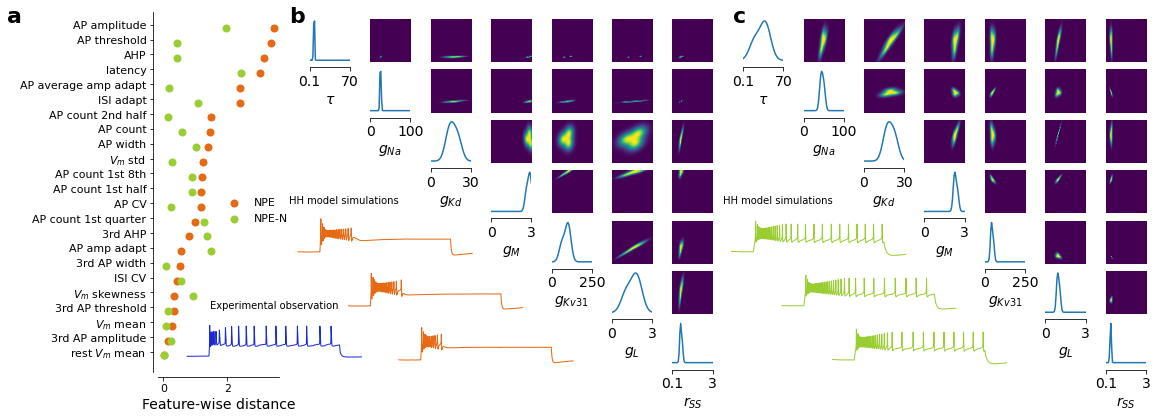

In [472]:
dims_to_show = [2, 4, 5, 6, 7, 8, 12]

fig = plt.figure(figsize=(14, 5))
ax_list = create_figure_hor(fig)

ax_features = ax_list[0]

# Feature-wise performances NPE vs NPE+
order = np.argsort(npe_score)

ax_features.scatter(
    npe_score[order],
    np.linspace(0, 4 * len(ephys_features) + 1, num=len(ephys_features)),
    color="#e66913ff",
    label="NPE",
    lw=2,
)
ax_features.scatter(
    npep_score[order],
    np.linspace(0, 4 * len(ephys_features) + 1, num=len(ephys_features)),
    color="yellowgreen",
    label="NPE-N",
    lw=2,
)
adjust_spines(ax_features, spines=["bottom", "left"])
ax_features.set_yticks(
    np.linspace(1, 4 * len(ephys_features) + 2, num=len(ephys_features))
)
ax_features.legend(loc=(0.5, 0.4), fontsize=11, frameon=False)
ax_features.set_xlabel("Feature-wise distance", fontsize=14)
ax_features.set_yticklabels(ephys_features[order])
ax_features.tick_params(axis="y", which="major", labelsize=11)
ax_features.tick_params(axis="x", which="major", labelsize=11)

ax_observation = ax_list[1]

# Experimental observation
ax_observation.plot(observation["time"], observation["data"], c="#1929d3ff", lw=lw)
ax_observation.set_ylim(
    [ax_observation.get_ylim()[0] - 30, ax_observation.get_ylim()[1] + 30]
)
ax_observation.set_xticks([])
ax_observation.set_yticks([])
sns.despine(ax=ax_observation, bottom=True, left=True)
ax_observation.set_title('Experimental observation', fontsize=10)

axes_npe = ax_list[2]

# npe pairplot
pairplot(
    npe_samples[:, dims_to_show],
    limits=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    ticks=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    labels=np.array(model_param_names[dims_to_show]),
    points_offdiag={"markersize": 6},
    points_colors="r",
    fig=fig,
    axes=axes_npe,
    upper="kde",
    diag="kde",
)

ax_npe_s1, ax_npe_s2, ax_npe_s3 = ax_list[4], ax_list[5], ax_list[6]

ax_npe_s1.plot(x_npe["time"], x_npe["data"][0, 0, :], lw=lw, color="#e66913ff")
ax_npe_s2.plot(x_npe["time"], x_npe["data"][1, 0, :], lw=lw, color="#e66913ff")
ax_npe_s3.plot(x_npe["time"], x_npe["data"][2, 0, :], lw=lw, color="#e66913ff")

axes_npep = ax_list[3]

# npe-n pairplot
pairplot(
    npep_samples[:, dims_to_show],
    limits=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    ticks=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    labels=np.array(model_param_names[dims_to_show]),
    points_offdiag={"markersize": 6},
    points_colors="r",
    fig=fig,
    axes=axes_npep,
    upper="kde",
    diag="kde",
)

ax_npep_s1, ax_npep_s2, ax_npep_s3 = ax_list[7], ax_list[8], ax_list[9]

ax_npep_s1.plot(x_npep["time"], x_npep["data"][0, 0, :], lw=lw, color="yellowgreen")
ax_npep_s2.plot(x_npep["time"], x_npep["data"][1, 0, :], lw=lw, color="yellowgreen")
ax_npep_s3.plot(x_npep["time"], x_npep["data"][2, 0, :], lw=lw, color="yellowgreen")

for ax in [ax_npe_s1, ax_npe_s2, ax_npe_s3, ax_npep_s1, ax_npep_s2, ax_npep_s3]:
    ax.set_ylim([ax_observation.get_ylim()[0], ax_observation.get_ylim()[1]])
    ax.set_xlim([ax_observation.get_xlim()[0], ax_observation.get_xlim()[1]])
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True, left=True)
ax_npe_s1.set_title('HH model simulations', fontsize=10, loc='left')
ax_npep_s1.set_title('HH model simulations', fontsize=10, loc='left')

fig.text(-0.15, .97, "a", fontsize=22, fontweight="bold")
fig.text(0.13, .97, "b", fontsize=22, fontweight="bold")
fig.text(0.57, .97, "c", fontsize=22, fontweight="bold")

plt.savefig("figures/npe_npen_{}.pdf".format(cell_name), bbox_inches="tight", pad_inches=0)